In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('merged_urls_with_label.csv')

In [3]:
df.shape

(4000, 3)

In [4]:
df.head()

,Category,URL,Label
0,HAM,https://urlscan.io/result/e6cb5bed-fa87-4317-b...,0
1,HAM,https://www.mercadopago.com.br/added on May 26...,0
2,HAM,https://onedrive.live.com/about/es-us-signin/a...,0
3,HAM,http://url.zp.edu.ua/added on May 26th 2023 5:...,0
4,HAM,https://bitflyer.com/en-us/added on May 26th 2...,0


**Lexical Feature Extraction:**

In [5]:
from urllib.parse import urlparse

# Step 1: Components Extraction Algorithm
def extract_components_from_url(url):
    parser = urlparse(url)
    segment = parser.scheme
    netloc = parser.netloc
    path = parser.path
    query = parser.query
    fragment = parser.fragment
    return segment, netloc, path, query, fragment

# Step 2: Features Extraction Algorithm
def extract_features_from_components(segment_list, netloc_list, path_list, query_list, fragment_list):
    features_list = []
    num_features = len(segment_list)
    for i in range(num_features):
        segment = segment_list[i]
        netloc = netloc_list[i]
        path = path_list[i]
        query = query_list[i]
        fragment = fragment_list[i]

        # Lexical feature extraction
        segment_features = len(segment)
        netloc_features = len(netloc)
        path_features = len(path)
        query_features = len(query)
        fragment_features = len(fragment)

        # Combine all features
        features = [segment_features, netloc_features, path_features, query_features, fragment_features]
        features_list.append(features)
    return features_list

In [6]:
# Components Extraction
segment_list = []
netloc_list = []
path_list = []
query_list = []
fragment_list = []

for url in df['URL']:
    segment, netloc, path, query, fragment = extract_components_from_url(url)
    segment_list.append(segment)
    netloc_list.append(netloc)
    path_list.append(path)
    query_list.append(query)
    fragment_list.append(fragment)

# Features Extraction
features_list = extract_features_from_components(segment_list, netloc_list, path_list, query_list, fragment_list)

# Create a new DataFrame with the extracted features
df_features = pd.DataFrame(features_list, columns=['Segment', 'Netloc', 'Path', 'Query', 'Fragment'])

# Concatenate the original DataFrame and the extracted features DataFrame
df_combined = pd.concat([df, df_features], axis=1)

# Save the extracted features to a CSV file
df_combined.to_csv('extracted_features.csv', index=False)

# Display the updated DataFrame
print(df_combined.head())

  Category                                                URL  Label  Segment  \
0      HAM  https://urlscan.io/result/e6cb5bed-fa87-4317-b...      0        5   
1      HAM  https://www.mercadopago.com.br/added on May 26...      0        5   
2      HAM  https://onedrive.live.com/about/es-us-signin/a...      0        5   
3      HAM  http://url.zp.edu.ua/added on May 26th 2023 5:...      0        4   
4      HAM  https://bitflyer.com/en-us/added on May 26th 2...      0        5   

   Netloc  Path  Query  Fragment  
0      10    78      0         0  
1      22    31      0         0  
2      17    50      0         0  
3      13    31      0         0  
4      12    37      0         0  


**ML Modelling:**

In [7]:
import threading
import queue
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [8]:
def modelics(X_train, y_train, X_test, queue, model):
    clf = model.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    queue.put((model.__class__.__name__, prediction))

def decision_maker(predictions):
    counts = {}
    for model_name, label in predictions:
        label_tuple = tuple(label)
        if label_tuple not in counts:
            counts[label_tuple] = 0
        counts[label_tuple] += 1

    max_count = max(counts.values())
    final_label = None
    for label, count in counts.items():
        if count == max_count:
            if final_label is not None:
                final_label = 'Tie'
                break
            final_label = np.array(label)

    return final_label

In [9]:
# Load data from CSV
data = pd.read_csv('extracted_features.csv')

features_list = data[['Segment', 'Netloc', 'Path', 'Query', 'Fragment']]
labels_list = data['Label']

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features_list, labels_list, test_size=0.5)


In [10]:
# One-hot encode categorical features
features_list_encoded = pd.get_dummies(features_list)

models = [
    AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',random_state=0),

    GradientBoostingClassifier(loss='log_loss',n_estimators=100,learning_rate=0.1,subsample=1.0,criterion='friedman_mse', min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,min_impurity_decrease=0.0,init=None,
                               random_state=0, max_features=None,verbose=0, max_leaf_nodes=None,warm_start=False,validation_fraction=0.1,
                               n_iter_no_change=None,tol=0.0001),

    DecisionTreeClassifier(criterion='gini',splitter='best',min_samples_split=2,min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                           max_features=None,random_state=0,max_leaf_nodes=None,min_impurity_decrease=0.0),

    ExtraTreesClassifier(n_estimators=100,criterion='gini',min_samples_split=2, min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                         max_leaf_nodes=None,min_impurity_decrease=0.0,bootstrap=False,oob_score=False,random_state=0,
                         verbose=0, warm_start=False, class_weight='balanced_subsample',ccp_alpha=0),

    BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=10, max_features=1.0, bootstrap=True,
                      bootstrap_features=False,oob_score=False,warm_start=False,random_state=0,verbose=0),

    RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,min_samples_split=2,min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,max_leaf_nodes=None,min_impurity_decrease=0.0,bootstrap=True,
                           oob_score=False,random_state=0,verbose=0,warm_start=False,class_weight='balanced_subsample'),

    KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto',leaf_size=30,p=2,metric='minkowski',metric_params=None),

    LogisticRegression(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,intercept_scaling=1,class_weight='balanced',
                       random_state=0,solver='saga', multi_class='ovr', verbose=0,warm_start=False,l1_ratio=None),

    SVC(gamma='scale'),

    MLPClassifier(alpha=1e-5,hidden_layer_sizes=(10, 10),random_state=1)
]

In [11]:
prediction_queue = queue.Queue()
threads_list = []


for model in models:
    thread = threading.Thread(target=modelics, args=(features_list, labels_list, features_list, prediction_queue, model))
    thread.start()
    threads_list.append(thread)

predictions = []

for thread in threads_list:
    thread.join()
    predictions.append(prediction_queue.get())

final_label = decision_maker(predictions)
print("Final Label:", final_label)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Final Label: [0 1 1 ... 1 1 1]


In [12]:
from sklearn.metrics import confusion_matrix

def calculate_evaluation_metrics(y_true, y_pred):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate evaluation metrics
    sensitivity = tp / (tp + fn)
    fall_out = fp / (fp + tn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = sensitivity
    f1_measure = 2 * (precision * recall) / (precision + recall)

    return sensitivity, fall_out, specificity, accuracy, precision, recall, f1_measure


In [13]:
evaluation_results = []  # List to store the evaluation results for each model

for model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Predict labels for the test dataset
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    sensitivity, fall_out, specificity, accuracy, precision, recall, f1_measure = calculate_evaluation_metrics(y_test, y_pred)

    # Store the evaluation results
    evaluation_results.append({
        'Model': model.__class__.__name__,
        'Sensitivity': sensitivity,
        'Fall-Out': fall_out,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Measure': f1_measure
    })

# Print the evaluation results for each model
for result in evaluation_results:
    print(f"Model: {result['Model']}")
    print(f"Sensitivity: {result['Sensitivity']}")
    print(f"Fall-Out: {result['Fall-Out']}")
    print(f"Specificity: {result['Specificity']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-Measure: {result['F1-Measure']}")
    print("------------------------")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: AdaBoostClassifier
Sensitivity: 0.8306613226452906
Fall-Out: 0.20059880239520958
Specificity: 0.7994011976047904
Accuracy: 0.815
Precision: 0.8048543689320389
Recall: 0.8306613226452906
F1-Measure: 0.8175542406311637
------------------------
Model: GradientBoostingClassifier
Sensitivity: 0.7915831663326653
Fall-Out: 0.1626746506986028
Specificity: 0.8373253493013972
Accuracy: 0.8145
Precision: 0.8289611752360966
Recall: 0.7915831663326653
F1-Measure: 0.8098411071245516
------------------------
Model: DecisionTreeClassifier
Sensitivity: 0.8226452905811623
Fall-Out: 0.18862275449101795
Specificity: 0.811377245508982
Accuracy: 0.817
Precision: 0.8128712871287128
Recall: 0.8226452905811623
F1-Measure: 0.8177290836653387
------------------------
Model: ExtraTreesClassifier
Sensitivity: 0.8236472945891784
Fall-Out: 0.18862275449101795
Specificity: 0.811377245508982
Accuracy: 0.8175
Precision: 0.8130563798219584
Recall: 0.8236472945891784
F1-Measure: 0.8183175709308114
----------------

In [14]:
from sklearn.metrics import classification_report
for model in models:
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict labels

    # Calculate evaluation metrics
    report = classification_report(y_test, y_pred)

    # Print evaluation report
    print(f"Model: {model.__class__.__name__}")
    print(report)
    print("------------------------")

Model: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1002
           1       0.80      0.83      0.82       998

    accuracy                           0.81      2000
   macro avg       0.82      0.82      0.81      2000
weighted avg       0.82      0.81      0.81      2000

------------------------
Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1002
           1       0.83      0.79      0.81       998

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000

------------------------
Model: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1002
           1       0.81      0.82      0.82       998

    accuracy                           0.8

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model: SVC
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1002
           1       0.82      0.67      0.73       998

    accuracy                           0.76      2000
   macro avg       0.77      0.76      0.76      2000
weighted avg       0.77      0.76      0.76      2000

------------------------
Model: MLPClassifier
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1002
           1       0.76      0.64      0.70       998

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.73      0.72      0.72      2000

------------------------


**Plot:**

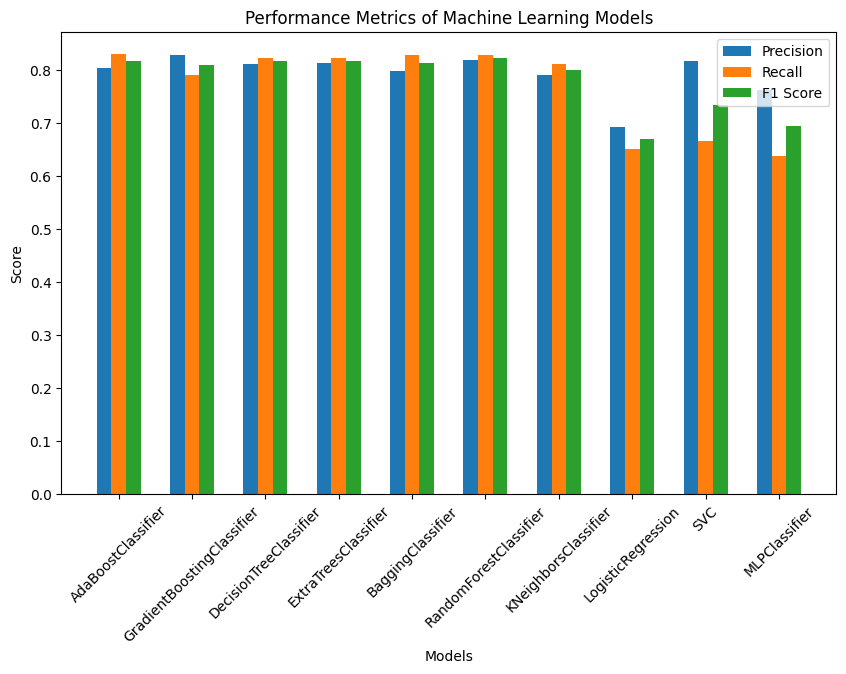

In [15]:
# Extract the performance metrics (precision, recall, and F1 score) for each model from the evaluation results:
precision = [result['Precision'] for result in evaluation_results]
recall = [result['Recall'] for result in evaluation_results]
f1_score = [result['F1-Measure'] for result in evaluation_results]

# Set the model names for the x-axis:
model_names = [result['Model'] for result in evaluation_results]

# Set the width of the bars:
bar_width = 0.2

# Set the positions of the bars on the x-axis:
index = np.arange(len(model_names))

# Plot the performance metrics using a bar chart or a line plot:

plt.figure(figsize=(10, 6))
plt.bar(index, precision, width=bar_width, label='Precision')
plt.bar(index + bar_width, recall, width=bar_width, label='Recall')
plt.bar(index + 2 * bar_width, f1_score, width=bar_width, label='F1 Score')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Performance Metrics of Machine Learning Models')
plt.xticks(index + bar_width, model_names, rotation=45)
plt.legend()

# Show the plot
plt.show()


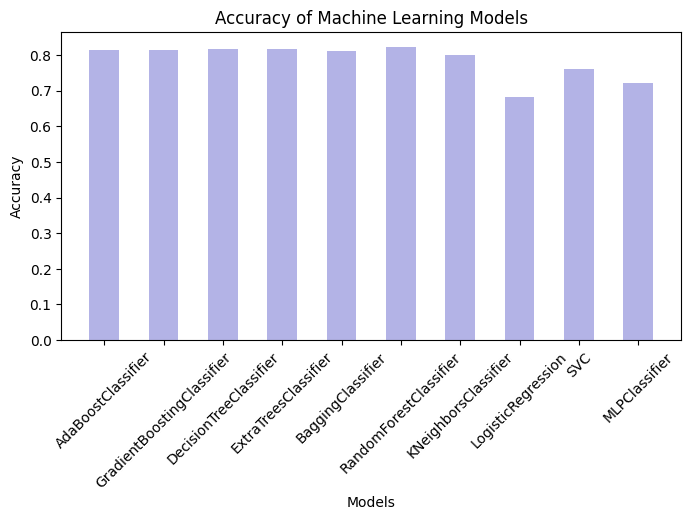

In [16]:
# Extract the accuracies for each model from the evaluation results:
accuracy = [result['Accuracy'] for result in evaluation_results]

# Define the pastel color for accuracy
pastel_color = (0.7, 0.7, 0.9)  # RGB values for a pastel color

# Plot Accuracy
plt.figure(figsize=(8, 4))
plt.bar(index, accuracy, width=0.5, color=pastel_color)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Machine Learning Models')
plt.xticks(index, model_names, rotation=45)
plt.show()